<a href="https://colab.research.google.com/github/pabloac31/TFG/blob/master/cifar10_experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Clone the repository**

In [1]:
! git clone https://github.com/pabloac31/TFG.git
%cd TFG

Cloning into 'TFG'...
remote: Enumerating objects: 73, done.
remote: Counting objects: 100% (73/73), done.
remote: Compressing objects: 100% (65/65), done.
remote: Total 256 (delta 43), reused 16 (delta 8), pack-reused 183
Receiving objects: 100% (256/256), 217.42 MiB | 36.44 MiB/s, done.
Resolving deltas: 100% (136/136), done.
Checking out files: 100% (30/30), done.
/content/TFG


**Using Tensorflow v1**

In [2]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


**Import libraries**

In [0]:
from cifar10_models import *
from utils import *
from adversarial_attacks import *

**Use CUDA if available**

In [4]:
use_cuda=True
print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

CUDA Available:  True


**Create dataloaders**

Load CIFAR10 test images as tensors of size NxCxHxW normalized with CIFAR10 mean and std.

In [5]:
test_loader = testloader_cifar10('./data', batch_size=256, shuffle=False)   # Used to test the models
adv_loader = testloader_cifar10('./data', batch_size=1)                     # Used for adversarial attacks
univ_loader = testloader_cifar10('./data', batch_size=1000, shuffle=False)  # Used for the X-set in the universal attack
full_loader = testloader_cifar10('./data', batch_size=10000, shuffle=False) # Used to calculate the overall fooling rate in the universal attack

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


**Load models pretrained on CIFAR10**

In [0]:
resnet = resnet50(pretrained=True)
densenet = densenet169(pretrained=True)
mobnet = mobilenet_v2(pretrained=True)
iv3 = inception_v3(pretrained=True)

**Test models**

In [0]:
acc = test_model(resnet, device, test_loader)
print('\nAccuracy on the CIFAR10 test set:', acc)

100%|██████████| 40/40 [00:05<00:00,  7.40it/s]


Accuracy on CIFAR10 test set:  0.9212


**Set method parameters**

In [0]:
params_fgsm = {'epsilon': 0.01, 'clip': True}
params_deepfool = {'num_classes': 10, 'overshoot': 0.01, 'max_iter': 50, 'p': 2, 'clip': True}
params_sparsefool = {'delta': 255, 'lambda_': 3.0, 'max_iter': 50, 'epsilon': 0.02}
params_opa = {'dim': 1, 'target_label': None, 'iters': 100, 'pop_size': 400, 'verbose': True}

**Testing a method on a random CIFAR10 image**

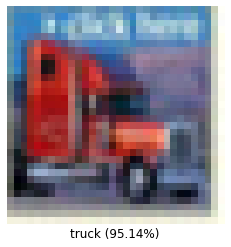

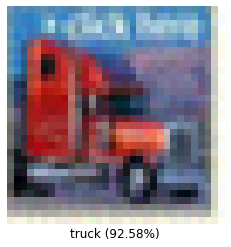

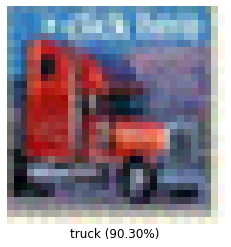

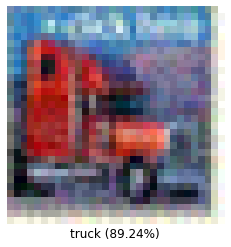

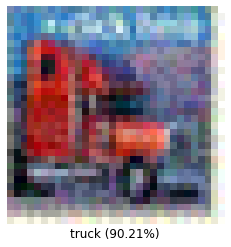

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


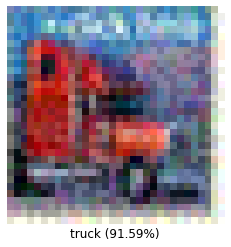

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


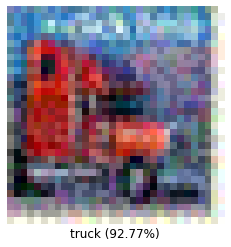

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


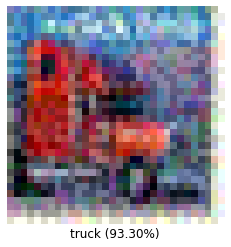

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


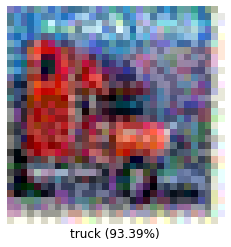

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


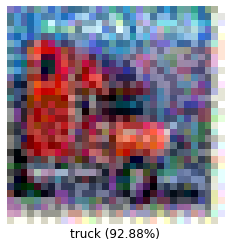

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


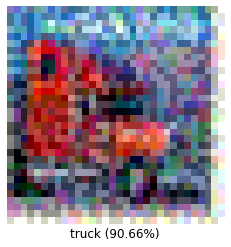

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


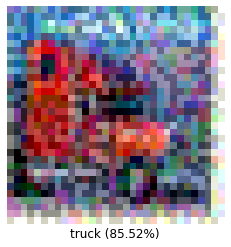

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


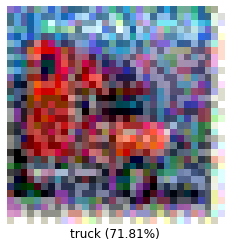

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


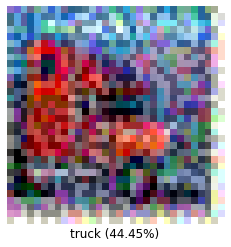

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


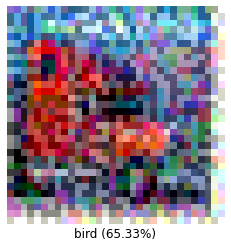

0.15


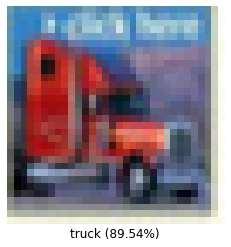

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


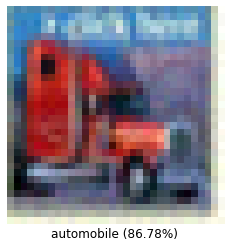

0.02


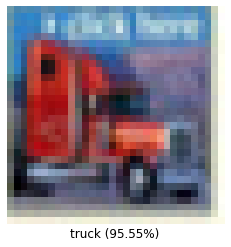

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


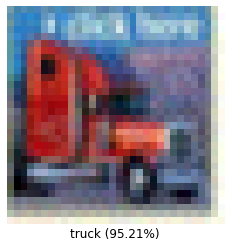

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


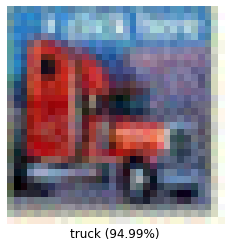

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


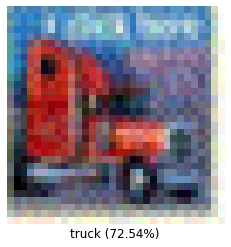

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


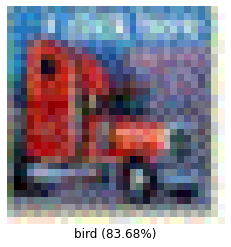

0.05


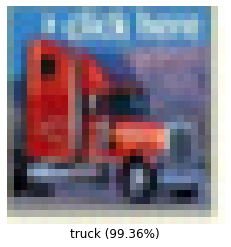

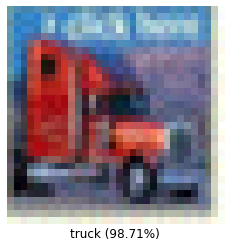

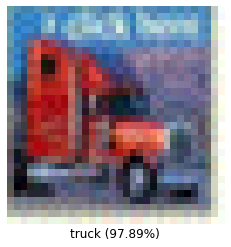

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


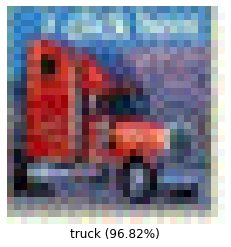

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


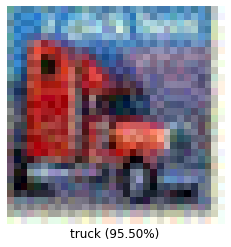

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


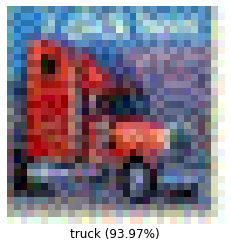

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


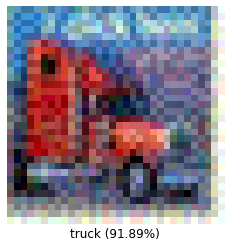

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


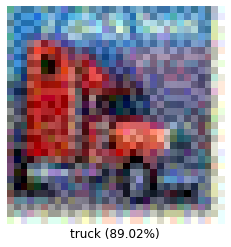

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


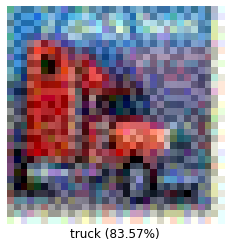

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


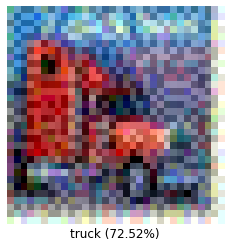

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


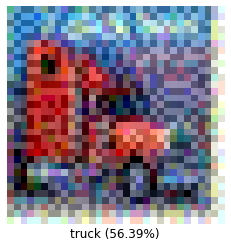

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


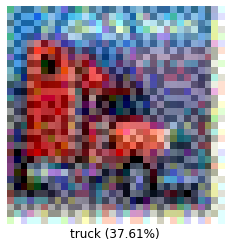

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


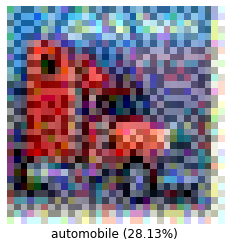

0.12999999999999998


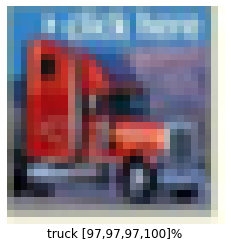

In [27]:
image, label = next(iter(adv_loader))
while label.item() != 9:
  image, label = next(iter(adv_loader))

p = [0,0,0,0]
for i, model in enumerate([resnet, densenet, mobnet, iv3]):
  params_fgsm = {'epsilon': 0.01, 'clip': True}
  attack_failed = True
  for j in range(50): 
    attack_failed, p[i] = test_method(model, device, image.clone(), label.clone(), method='fgsm', params=params_fgsm, show_pert=False)
    if not attack_failed or i > 100:
      print(params_fgsm['epsilon'])
      break
    else:
      params_fgsm['epsilon'] += 0.01

fun(image.clone(), " [{:.0f},{:.0f},{:.0f},{:.0f}]%".format(p[0],p[1],p[2],p[3]))

In [0]:
def fun(img, confs=''):
  f = plt.figure()
  plt.imshow(displayable(img))
  plt.axis('off')
  f.text(.51, .08, cifar10_classes[label.item()] + confs, ha='center', fontsize=12)

In [0]:
def test_method(model, device, img, label, method, params, show_pert=True):

  img = img.clone()

  model = model.to(device).eval()

  x = img.to(device)
  label = label.to(device)

  if method in ['fgsm', 'deepfool', 'sparsefool']:
    x.requires_grad = True

  y = model(x)
  init_pred = y.max(1, keepdim=True)[1]
  x_conf = F.softmax(y, dim=1).max(1, keepdim=True)[0].item()

  if init_pred.item() != label.item():
    print("Wrong classification...")
    return

  # Call method
  if method == 'fgsm':
    adv_x, pert_x = fgsm(model, x, label, y, params["epsilon"], params["clip"])

  elif method == 'deepfool':
    _, adv_x, pert_x, n_iter = deepfool(model, device, x, params["num_classes"], overshoot=params["overshoot"], max_iter=params["max_iter"], p=params["p"], clip=params["clip"])

  elif method == 'sparsefool':
    # Generate lower and upper bounds
    delta = params["delta"]
    lb, ub =  valid_bounds(x, delta, dataset='cifar10')
    lb = lb[None, :, :, :].to(device)
    ub = ub[None, :, :, :].to(device)
    adv_x, pert_x, n_iter = sparsefool(model, device, x, label.item(), lb, ub, params["lambda_"], params["max_iter"], params["epsilon"])

  elif method == 'one_pixel_attack':
    adv_x, n_iter, scores = one_pixel_attack(model, device, x, label.item(), params["dim"], params["target_label"], params["iters"], params["pop_size"], params["verbose"])
    pert_x = adv_x - x

  y_adv = model(adv_x)
  adv_pred = y_adv.max(1, keepdim=True)[1]
  adv_x_conf = F.softmax(y_adv, dim=1).max(1, keepdim=True)[0].item()

  # Plot results
  if show_pert:
    f = plt.figure()
    f.add_subplot(1,3,1)
    plt.title('Original image')
    plt.axis('off')
    f.text(.25, .3, cifar10_classes[label.item()] + ' ({:.2f}%)'.format(x_conf*100), ha='center')
    plt.imshow(displayable(img))
    f.add_subplot(1,3,2)
    plt.title('Perturbation')
    plt.axis('off')
    plt.imshow(displayable(pert_x.cpu().detach()))
    f.add_subplot(1,3,3)
    plt.title('Adv. image')
    plt.axis('off')
    f.text(.8, .3, cifar10_classes[adv_pred.item()] + ' ({:.2f}%)'.format(adv_x_conf*100), ha='center')
    plt.imshow(displayable(adv_x.cpu().detach()))
    plt.show(block=True)

  else:
    f = plt.figure()
    plt.axis('off')
    f.text(.51, .08, cifar10_classes[adv_pred.item()] + ' ({:.2f}%)'.format(adv_x_conf*100), ha='center', fontsize=12)
    plt.imshow(displayable(adv_x.cpu().detach()))
    plt.show(block=True)

  if method in ['deepfool',  'sparsefool', 'one_pixel_attack']:
    print('Number of iterations needed: ', n_iter)

  if method == 'sparsefool':
    pert_pixels = pert_x.flatten().nonzero().size(0)
    print('Number of perturbed pixels: ', pert_pixels)

  #if method == 'one_pixel_attack':
    #return scores

  return adv_pred.item() == label.item(), x_conf*100

**Perform a complete attack and show the results**

In [0]:
adv_examples = attack_model(resnet, device, adv_loader, 'deepfool', params_deepfool)

**Preparing datasets for the universal method**

In [0]:
# Images on the set X used to compute the universal perturbation
dataset, labels = next(iter(univ_loader))
print(dataset.size())

# Images on the CIFAR10 test set, used to calculate the overall fooling rate
testset, labels_test = next(iter(full_loader))
print(testset.size())

torch.Size([1000, 3, 32, 32])
torch.Size([10000, 3, 32, 32])


**Obtaining an universal perturbation**

In [0]:
v, fooling_rate = universal_perturbation(dataset, labels, resnet, device, delta=0.2, xi=3*5, max_iter_uni=10, p=2)
print('Fooling rate on X:', fooling_rate)

  0%|          | 0/1000 [00:00<?, ?it/s]

Starting pass number  0


  0%|          | 0/1000 [00:00<?, ?it/s]

FOOLING RATE =  0.695
Starting pass number  1


  0%|          | 0/1000 [00:00<?, ?it/s]

FOOLING RATE =  0.727
Starting pass number  2


100%|██████████| 10/10 [00:00<00:00, 12.21it/s]

FOOLING RATE =  0.8
Total time: 306.78
Total iters: 3
Norm of the univ. perturbation: 14.999999046325684
Fooling rate on X: 0.8


**Calculate the overall fooling rate**

In [0]:
univ_fool_rate(resnet, device, testset, v, batch_size=250)

100%|██████████| 100/100 [00:08<00:00, 12.14it/s]


0.7606

**Save/load an universal perturbation**

In [0]:
torch.save(v, 'resnet_15.pt') 
#v = torch.load('resnet_15.pt')

**Show some adversarial examples obtained from the universal perturbation v**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


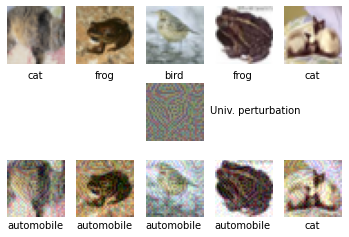

In [0]:
show_univ_examples(5, resnet, device, v)

**Show the universal perturbation**

tensor(25.5024, device='cuda:0')


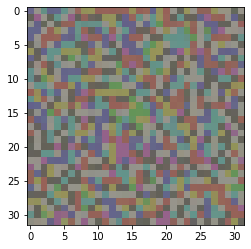

In [0]:
plt.axis('off')
plt.imshow(displayable(v.cpu()))